In [1]:
# https://www.kaggle.com/code/zwhjorth/dnn-svm-and-dt-for-fraud-detection

In [1]:
# importing the necessary libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from matplotlib import pyplot as plt

In [2]:
Data = pd.read_csv('card_transdata.csv')
Data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
Data['Log_home'] = np.log10(Data['distance_from_home'])
Data['Log_trans'] = np.log10(Data['distance_from_last_transaction'])
Data['Log_ratio'] = np.log10(Data['ratio_to_median_purchase_price'])

In [ ]:
# sns.pairplot(data=Data[['Log_home','Log_trans','Log_ratio','fraud']], hue = 'fraud')
# plt.show()

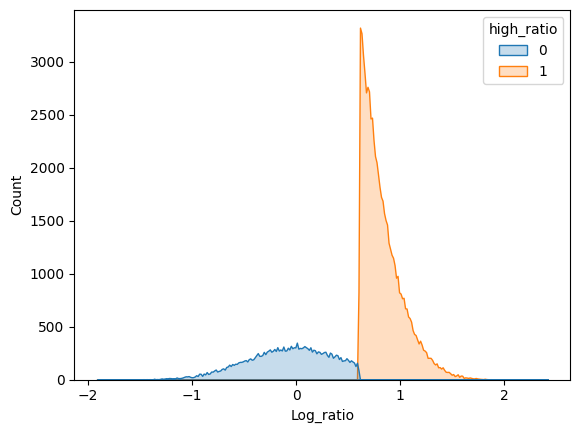

In [ ]:
Data['high_ratio'] = np.where(Data['Log_ratio'] > 0.6, 1, 0)


In [4]:
X = Data.drop(columns = ['fraud', 'Log_home','Log_trans','Log_ratio'])
y = Data['fraud']

# Splitting the data into test and train

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train)

# It is important to only fit the scaler to the training data, otherwise you are leaking
# information about the global distribution of variables (which is influenced by the test set)
# into the train set.

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

# Getting class weights

class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [5]:
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = len(X.columns)))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-06-14 11:36:07.467379: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-14 11:36:07.467595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [6]:
model.fit(X_train, y_train, epochs=2, \
                    validation_data=(scaler.transform(X_val),y_val), \
                    verbose = True, class_weight = class_weights)

Epoch 1/2


2023-06-14 11:36:12.280120: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-14 11:36:12.541175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19997/20000 [============================>.] - ETA: 0s - loss: 0.0753 - accuracy: 0.9669

2023-06-14 11:39:35.346394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20000/20000 [==============================] - 219s 11ms/step - loss: 0.0752 - accuracy: 0.9669 - val_loss: 0.0585 - val_accuracy: 0.9757
Epoch 2/2
20000/20000 [==============================] - 214s 11ms/step - loss: 0.0417 - accuracy: 0.9822 - val_loss: 0.0845 - val_accuracy: 0.9692


In [7]:
y_pred_temp = model.predict(scaler.transform(X_test)) 

  35/6250 [..............................] - ETA: 19s 

2023-06-14 11:43:25.701540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6250/6250 [==============================] - 15s 2ms/step


In [21]:
threshold = 0.9

y_pred = np.where(y_pred_temp > threshold, 1,0)
c_matrix = confusion_matrix(y_test,y_pred)
print(c_matrix)
class_report = classification_report(y_test, y_pred)
print(class_report)



[[180120   2399]
 [    68  17413]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    182519
         1.0       0.88      1.00      0.93     17481

    accuracy                           0.99    200000
   macro avg       0.94      0.99      0.96    200000
weighted avg       0.99      0.99      0.99    200000

